In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install numpy matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
import torch 
from torch import nn
import torchvision
from torchvision.transforms import ToTensor
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import optim


In [3]:
train_model = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
trainloaderv0 = DataLoader(train_model,batch_size=32,shuffle=True,num_workers=2)
test_model = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())
testloaderv0 = DataLoader(train_model,batch_size=32,shuffle=True,num_workers=2)

len(train_model),len(trainloaderv0),len(test_model),len(testloaderv0)

Files already downloaded and verified
Files already downloaded and verified


(50000, 1563, 10000, 1563)

In [4]:
img,label = train_model[0]
print(img.shape)
print("Label:",label)
print('Img')
img
    

torch.Size([3, 32, 32])
Label: 6
Img


tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0.

In [5]:
classes = train_model.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [7]:
def show_example(img,label):
    print('Label:',train_model.classes[label],"(" + str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label: truck (9)


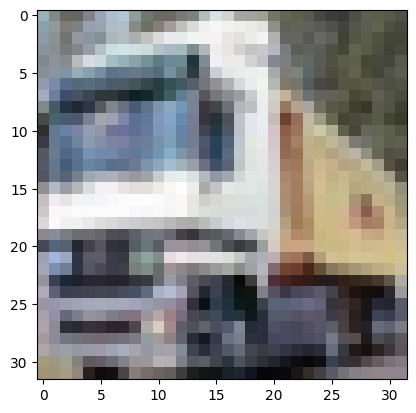

In [8]:
show_example(*train_model[1])

Label: automobile (1)


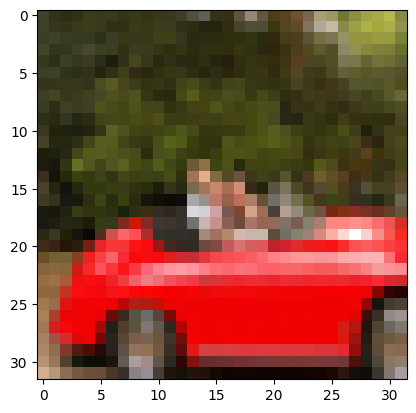

In [9]:
show_example(*train_model[99])

In [10]:
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
class CNNModelV0(ImageClassificationBase):
    def __init__(self):
        super(CNNModelV0, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)     # Hidden layer 1
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    # Hidden layer 2
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)   # Hidden layer 3
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # Hidden layer 4
        self.pool = nn.MaxPool2d(2, 2)                  # Auxiliary layer (Pooling)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)          # Hidden layer 5 (Fully connected)
        self.fc2 = nn.Linear(512, 10)                   # Output layer
        self.relu = nn.ReLU()                           # Activation function
        self.dropout = nn.Dropout(0.5)                  # Auxiliary layer (Dropout)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [12]:
model_v0 = CNNModelV0()
device = 'cpu'
model_v0.to(device)

CNNModelV0(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [13]:
from timeit import default_timer as timer
def print_train_time(start:float,end:float,device:torch.device=None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [14]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [15]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "loss_func"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_v0.parameters(), lr=0.001)

In [16]:
from timeit import default_timer as timer
def print_train_time(start:float,end:float,device:torch.device=None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [17]:
def train_model(model, trainloader, loss_func, optimizer, epochs=10):
    history = {'train_loss': [], 'val_acc': []}
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_loss = running_loss / len(trainloader)
        val_acc = evaluate_model(model, testloaderv0)
        
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch + 1}, Loss: {train_loss}, Accuracy: {val_acc}')
    
    return history

def evaluate_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [18]:
def plot_accuracies(history):
    accuracies = history['val_acc']
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs')
    plt.show()

def plot_losses(history):
    losses = history['train_loss']
    plt.plot(losses, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Number of Epochs')
    plt.show()


Epoch 1, Loss: 1.562066595140971, Accuracy: 56.52
Epoch 2, Loss: 1.1312118479249116, Accuracy: 66.212
Epoch 3, Loss: 0.9399160862693555, Accuracy: 71.592
Epoch 4, Loss: 0.8095483112644096, Accuracy: 75.84
Epoch 5, Loss: 0.716352832990431, Accuracy: 79.09
Epoch 6, Loss: 0.6405894741730589, Accuracy: 80.436
Epoch 7, Loss: 0.571465297932817, Accuracy: 79.734
Epoch 8, Loss: 0.5162781974871572, Accuracy: 83.766
Epoch 9, Loss: 0.4606279780658025, Accuracy: 85.904
Epoch 10, Loss: 0.4204764384692934, Accuracy: 87.836


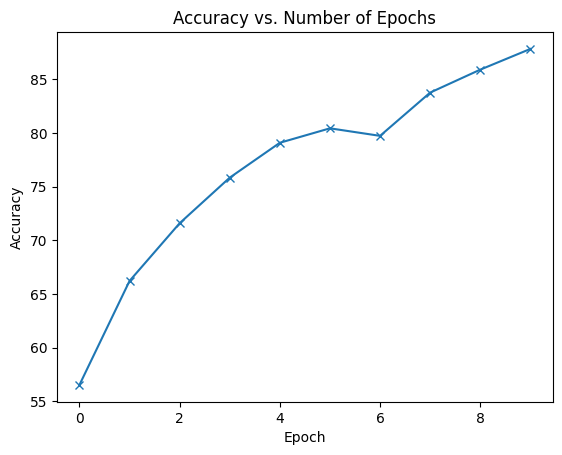

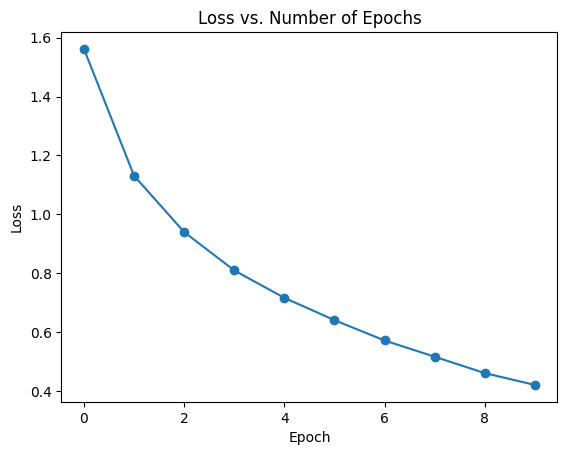

In [19]:
# Hyperparameters
learning_rate = 0.001
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v0.parameters(), lr=learning_rate)

# Training
history = train_model(model_v0, trainloaderv0, loss_fn, optimizer, epochs)

# Plotting
plot_accuracies(history)
plot_losses(history)


In [20]:
device = 'gpu'
model_v0_gpu = CNNModelV0().to('gpu')
# Hyperparameters
learning_rate = 0.001
epochs = 25

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v0_gpu.parameters(), lr=learning_rate)

# Training
history = train_model(model_v0_gpu, trainloaderv0, loss_fn, optimizer, epochs)

# Plotting
plot_accuracies(history)
plot_losses(history)



RuntimeError: Expected one of cpu, cuda, ipu, xpu, mkldnn, opengl, opencl, ideep, hip, ve, fpga, ort, xla, lazy, vulkan, mps, meta, hpu, mtia, privateuseone device type at start of device string: gpu

: 